In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gnan Data

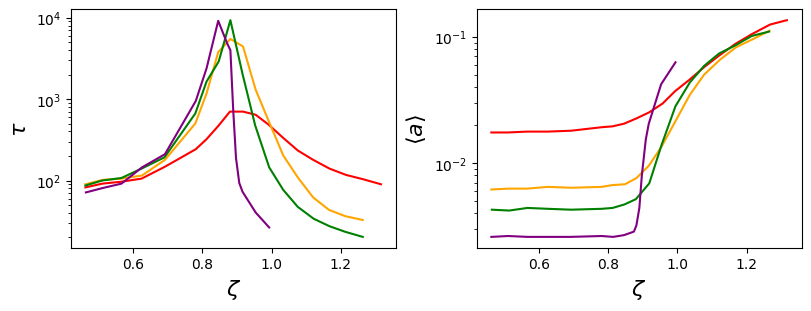

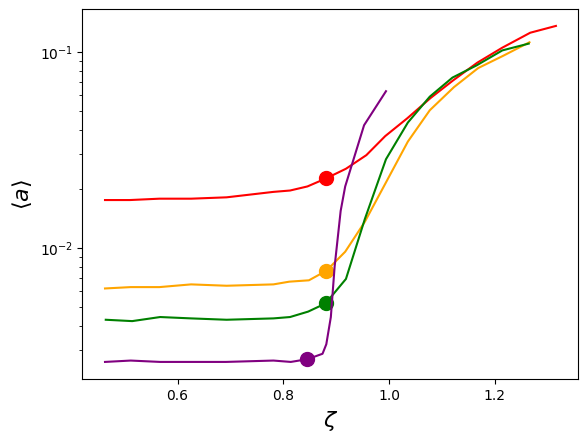

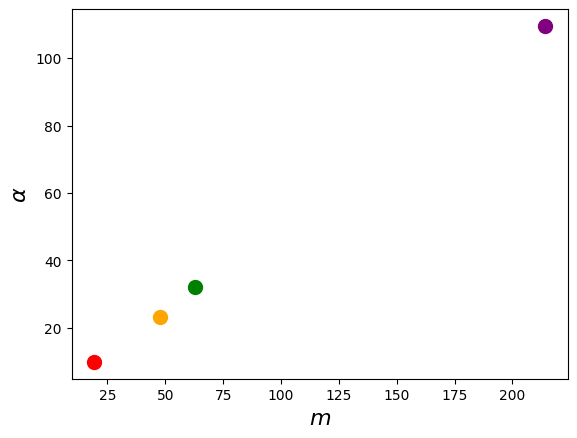

In [142]:
# get the density where tau is maximized
tau_density_df = pd.read_csv('tau_density.txt')
asphericity_density_df = pd.read_csv('asphericity_density.txt')
colors = ['r', 'o', 'g', 'p']
color_to_c = {"r": "red", "o": "orange", "g": "green", "p": "purple"}
color_to_U = {"r": 100, "o": 500, "g": 1000, "p": 3000, }
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3))
for c in colors:
    for a, df in zip(ax, [tau_density_df, asphericity_density_df]):
        x = df[f'{c}X'].values
        y = df[f'{c}Y'].values
        a.plot(x, y, color_to_c[c])
for a in ax:
    a.set_yscale('log')
    a.set_xlabel(r'$\zeta$', fontsize=16)
ax[0].set_ylabel(r'$\tau$', fontsize=16)
ax[1].set_ylabel(r'$\langle a \rangle$', fontsize=16)
plt.show()

asphericity_at_tau_star = []
for c in colors:
    density_1 = tau_density_df[f'{c}X'].values
    tau = tau_density_df[f'{c}Y'].values
    m = ~np.isnan(density_1) & ~np.isnan(tau)
    density_1 = density_1[m]
    tau = tau[m]

    density_2 = asphericity_density_df[f'{c}X'].values
    asphericity = asphericity_density_df[f'{c}Y'].values
    m = ~np.isnan(density_2) & ~np.isnan(asphericity)
    density_2 = density_2[m]
    asphericity = asphericity[m]
    
    i = np.argmin(np.abs(density_1[np.argmax(tau)] - density_2))
    asphericity_at_tau_star.append(asphericity[i])
    plt.plot(density_2, asphericity, c=color_to_c[c])
    plt.scatter(density_2[i], asphericity[i], c=color_to_c[c], s=100)
plt.xlabel(r'$\zeta$', fontsize=16)
plt.ylabel(r'$\langle a \rangle$', fontsize=16)
plt.yscale('log')
plt.show()

# asphericity variation vs m (logarithmic slope)
dps = np.array([[9.899434920026824, 19.260607221530506],
[23.160616799157175, 47.615170960635965],
[32.04482329278805, 62.87711904989945],
[109.54889378412028, 214.09826644957377],])
for c, alpha, m in zip(color_to_c.values(), dps[:, 0], dps[:, 1]):
    plt.scatter(m, alpha, c=c, s=100)
plt.xlabel(r'$m$', fontsize=16)
plt.ylabel(r'$\alpha$', fontsize=16)
plt.show()

# Shen Data

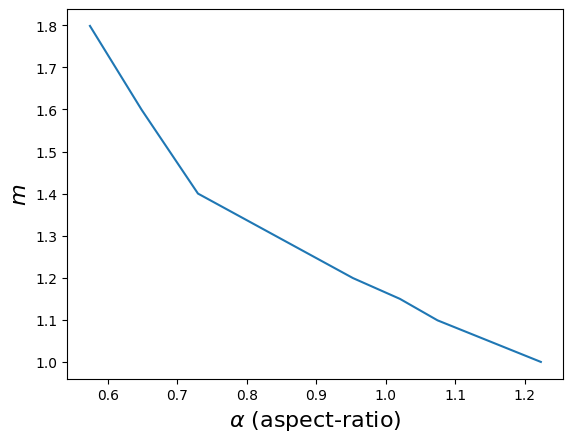

Text(0, 0.5, '$a$')

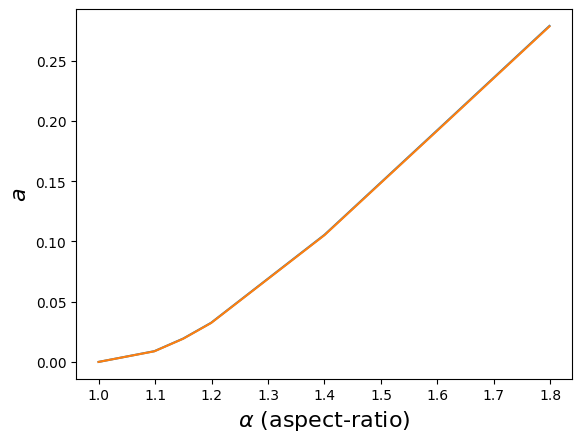

In [158]:
# m (logarithmic slope) vs aspect ratio (of an ellipse)

ellipses = np.array([[1, 1.2229729729729728],
[1.098804780876494, 1.0743243243243241],
[1.149800796812749, 1.0202702702702702],
[1.1992031872509958, 0.9527027027027026],
[1.4, 0.7297297297297296],
[1.599203187250996, 0.6486486486486487],
[1.798406374501992, 0.5743243243243243],])

plt.plot(ellipses[:, 1], ellipses[:, 0])
plt.xlabel(r'$\alpha$ (aspect-ratio)', fontsize=16)
plt.ylabel(r'$m$', fontsize=16)
plt.show()

from shapely.geometry import Point
from shapely.affinity import scale

def ellipse_polygon_from_aspect(aspect_ratio, area=np.pi, resolution=256):
    AR = float(aspect_ratio)
    if AR <= 0:
        raise ValueError("aspect_ratio must be > 0")

    # a*b is fixed by area = pi*a*b
    ab = area / np.pi
    a = np.sqrt(ab * AR)
    b = np.sqrt(ab / AR)

    # Shapely: resolution is segments-per-quadrant and must be an int
    resolution = int(resolution)

    # unit circle polygon -> scale to ellipse
    circle = Point(0.0, 0.0).buffer(1.0, resolution=resolution)
    ellipse_poly = scale(circle, xfact=a, yfact=b, origin=(0.0, 0.0))

    # boundary vertices (perimeter approximation)
    poly = np.asarray(ellipse_poly.exterior.coords, dtype=float)

    # center using the *polygon centroid* (more principled than averaging vertices)
    c = np.array([ellipse_poly.centroid.x, ellipse_poly.centroid.y], dtype=float)
    poly = poly - c
    return poly

def asphericity_from_points_xy(xy: np.ndarray) -> float:
    """Asphericity from a point cloud treated as equal-weighted point masses."""
    xy = np.asarray(xy, dtype=float)
    xy = xy - xy.mean(axis=0, keepdims=True)
    x = xy[:, 0]
    y = xy[:, 1]

    # gyration/covariance tensor (normalization cancels in the ratio, but helps numerics)
    G = np.array([[np.mean(x * x), np.mean(x * y)],
                  [np.mean(x * y), np.mean(y * y)]], dtype=float)

    lam = np.linalg.eigvalsh(G)  # sorted ascending
    return float(((lam[1] - lam[0]) / (lam[1] + lam[0])) ** 2)

def get_ellipse_asphericity_polygon(aspect_ratio, resolution=512):
    poly = ellipse_polygon_from_aspect(aspect_ratio, resolution=resolution)
    return asphericity_from_points_xy(poly)

def get_ellipse_asphericity_analytic(aspect_ratio):
    """Uniform-filled ellipse (area measure): b = ((a^2-b^2)/(a^2+b^2))^2.

    With a/b = AR, this simplifies to: ((AR - 1/AR)/(AR + 1/AR))^2.
    """
    AR = float(aspect_ratio)
    return ((AR - 1.0 / AR) / (AR + 1.0 / AR)) ** 2

ellipse_asphericity_poly = np.array([
    get_ellipse_asphericity_polygon(a, resolution=512) for a in ellipses[:, 0]
])
ellipse_asphericity_analytic = np.array([
    get_ellipse_asphericity_analytic(a) for a in ellipses[:, 0]
])

plt.plot(ellipses[:, 0], ellipse_asphericity_poly)
plt.plot(ellipses[:, 0], ellipse_asphericity_analytic)
plt.xlabel(r'$\alpha$ (aspect-ratio)', fontsize=16)
plt.ylabel(r'$a$', fontsize=16)

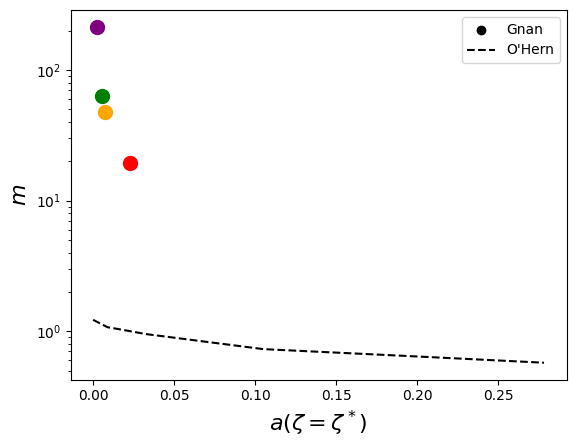

In [174]:
for c, a, m in zip(color_to_c.values(), asphericity_at_tau_star, dps[:, 1]):
    plt.scatter(a, m, c=c, s=100)
plt.scatter([], [], c='k', label='Gnan')
plt.plot(ellipse_asphericity_analytic, ellipses[:, 1], c='k', ls='--', label='O\'Hern')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$a(\zeta=\zeta^*)$', fontsize=16)
plt.ylabel(r'$m$', fontsize=16)
plt.savefig('fragility-asphericity-comparison.png', dpi=600)

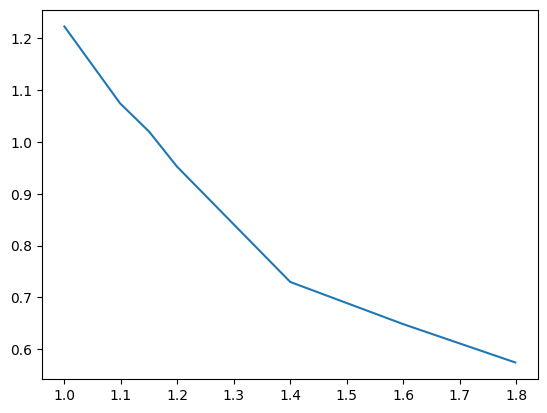

In [ ]:
# m (logarithmic slope) vs aspect ratio (of an ellipse)

ellipses = np.array([[1, 1.2229729729729728],
[1.098804780876494, 1.0743243243243241],
[1.149800796812749, 1.0202702702702702],
[1.1992031872509958, 0.9527027027027026],
[1.4, 0.7297297297297296],
[1.599203187250996, 0.6486486486486487],
[1.798406374501992, 0.5743243243243243],])
plt.plot(ellipses[:, 0], ellipses[:, 1])

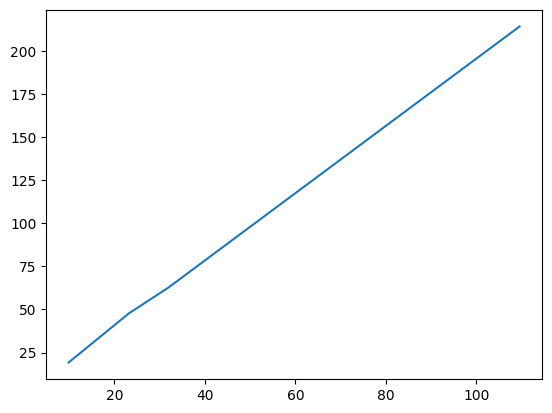

In [ ]:
# asphericity vs m (logarithmic slope)

dps = np.array([[9.899434920026824, 19.260607221530506],
[23.160616799157175, 47.615170960635965],
[32.04482329278805, 62.87711904989945],
[109.54889378412028, 214.09826644957377],])

plt.plot(dps[:, 0], dps[:, 1])

In [ ]:
# calculate the asphericity for ellipses with given aspect ratios



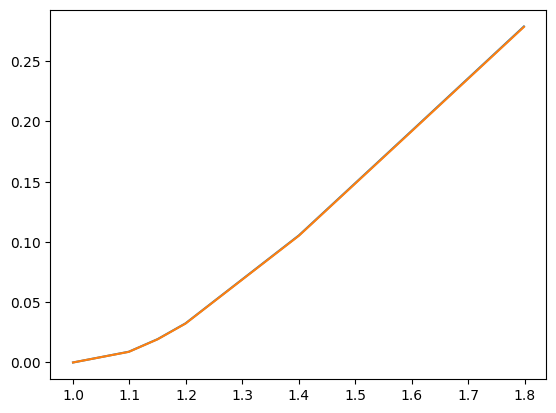

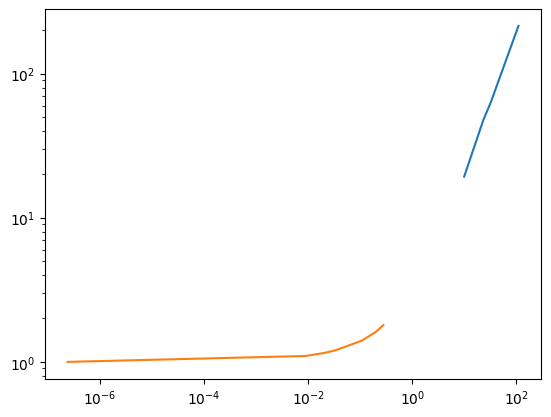

In [65]:
plt.plot(dps[:, 0], dps[:, 1])
plt.plot(ellipse_asphericity_poly, ellipses[:, 0])
plt.xscale('log')
plt.yscale('log')

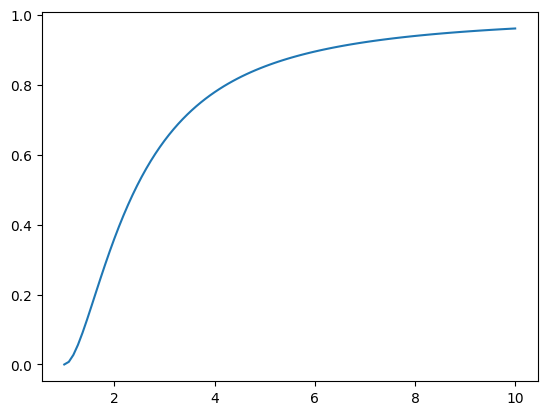

In [61]:
trial_aspect_ratios = np.linspace(1.0, 10.0, 100)
trial_asphericities = np.array([
    get_ellipse_asphericity_analytic(a) for a in trial_aspect_ratios
])

plt.plot(trial_aspect_ratios, trial_asphericities)